In [ ]:
import torch

from dataset import *
from utils import *


training_data = dataset("astrain/color", "astrain/label", target_transform=target_remap())
val_data = dataset("val/color", "val/label", target_transform=target_remap())
#test_data = dataset("rtest/color", "rtest/label", target_transform=target_remap())

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=diff_size_collate)
#test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True,collate_fn=diff_size_collate)

In [93]:
import numpy as np


In [94]:
import torch.nn as nn

class EncoderBlock(nn.Module):
    def __init__(self, din, dout):
        super().__init__()
        # Added BatchNorm for potentially better reconstruction training
        self.encoder_block = nn.Sequential(
            nn.Conv2d(din, dout, kernel_size=3, padding=1, bias= False), # Bias often False before BN
            nn.BatchNorm2d(dout),
            nn.ReLU(),
            # Add another Conv layer 
            nn.Conv2d(dout, dout, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(dout),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)   
        )
    
    def forward(self, x):
        return self.encoder_block(x)


class Encoder(nn.Module):
    def __init__(self, din):
        super().__init__()
        self.encoderPart1 = EncoderBlock(din, 64)
        self.encoderPart2 = EncoderBlock(64, 32)
        self.encoderPart3 = EncoderBlock(32, 16)
        # Store intermediate results if planning U-Net style skips later (Optional)
        self.features1 = None
        self.features2 = None
    
    def forward(self, x):
        self.features1 = self.encoderPart1(x)
        self.features2 = self.encoderPart2(self.features1)
        encoded_output = self.encoderPart3(self.features2)
        return encoded_output


class DecoderBlock(nn.Module):
    def __init__(self, din, dout):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.ConvTranspose2d(din, dout, kernel_size=2, stride=2), # Upsamples H, W by 2
            nn.Conv2d(dout, dout, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(dout),
            nn.ReLU(inplace=True),
            nn.Conv2d(dout, dout, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(dout),
            nn.ReLU(inplace=True)
            # Above code instead of below
            #nn.Conv2d(din, dout, kernel_size=3, padding=1),
            #nn.ReLU(),
            #nn.Upsample(scale_factor=2)
        )
        
    def forward(self, x):
        return self.decoder_block(x)


class Decoder(nn.Module):
    def __init__(self, dout):
        super().__init__()
        self.decoderBlock1 = DecoderBlock(16, 16)
        self.decoderBlock2 = DecoderBlock(16, 32)
        self.decoderBlock3 = DecoderBlock(32, 64)
        #self.decoderOut = nn.Sequential(
        #    nn.Conv2d(64, dout, kernel_size=3, padding=1),
        #    nn.Sigmoid()
        #)
        
    def forward(self, x):
        x = self.decoderBlock1(x)
        x = self.decoderBlock2(x)
        x = self.decoderBlock3(x)
        #x = self.decoderOut(x)
        return x


class SegmentationDecoder(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Input comes from the encoder, which outputs 16 channels
        encoder_output_channels = 16

        # Decoder blocks mirror the encoder structure in reverse
        # Input: B, 16, H/8, W/8
        self.decoderBlock1 = DecoderBlock(encoder_output_channels, 32) # Out: B, 32, H/4, W/4
        self.decoderBlock2 = DecoderBlock(32, 64)                      # Out: B, 64, H/2, W/2
        self.decoderBlock3 = DecoderBlock(64, 64)      
        
        #GPT prefers :
        # self.decoderBlock1 = DecoderBlock(encoder_output_channels, 32) # Out: B, 32, H/4, W/4
        #self.decoderBlock2 = DecoderBlock(32, 64)                      # Out: B, 64, H/2, W/2
        #self.decoderBlock3 = DecoderBlock(64, 64)                   # Out: B, 64, H, W

        # Final convolution to get scores for each class per pixel
        # Input channels = output channels of the last decoder block (64)
        # Output channels = number of segmentation classes
        self.finalConv = nn.Conv2d(64, num_classes, kernel_size=1)
        # Note: No Sigmoid/Softmax here! CrossEntropyLoss expects raw logits.

    def forward(self, x):
        x = self.decoderBlock1(x)
        x = self.decoderBlock2(x)
        x = self.decoderBlock3(x)
        x = self.finalConv(x) # Output: (B, num_classes, H, W) - raw scores (logits)
        return x


class ReconstructionAutoencoder(nn.Module):
    def __init__(self, din, dout):
        super().__init__()
        self.encoder = Encoder(din)
        self.decoder = Decoder(dout)
        self.decoderOut = nn.Sequential(
            nn.Conv2d(64, dout, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        reconstructed = self.decoderOut(decoded)
        return reconstructed
        

class SegmentationAutoencoder(nn.Module):
    def __init__(self, din, num_classes=4, pretrained_encoder_path=None):
        super().__init__()
        self.num_classes = num_classes

        # Initialize the Encoder
        self.encoder = Encoder(din)

        # Load pre-trained weights (if path provided)
        if pretrained_encoder_path:
            try:
                # Load the state dict of the *entire* Autoencoder first
                full_autoencoder_state_dict = torch.load(pretrained_encoder_path, map_location=lambda storage, loc: storage) # Load to CPU initially

                # Create a new state dict for the encoder only
                encoder_state_dict = {}
                for key, value in full_autoencoder_state_dict.items():
                    if key.startswith('encoder.'):
                        # Remove the 'encoder.' prefix to match the keys in self.encoder
                        new_key = key[len('encoder.'):]
                        encoder_state_dict[new_key] = value

                # Load the extracted state dict into the encoder
                self.encoder.load_state_dict(encoder_state_dict, strict=True)
                print(f"Successfully loaded pre-trained encoder weights from {pretrained_encoder_path}")

            except FileNotFoundError:
                print(f"Warning: Pre-trained encoder file not found at {pretrained_encoder_path}. Encoder weights are random.")
            except Exception as e:
                print(f"Warning: Error loading pre-trained encoder weights: {e}. Encoder weights might be random.")
                # You might want `strict=False` if the architectures slightly differ, but it's risky.

        # Freeze the Encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        print("Encoder parameters frozen.")

        # Initialize the Decoder
        self.decoder = Decoder(dout=self.num_classes)
        # Decoder parameters have requires_grad = True by default

        # Final convolution to get scores for each class per pixel
        self.finalConv = nn.Conv2d(64, num_classes, kernel_size=1)
        # No Sigmoid/Softmax here because CrossEntropyLoss expects raw logits

    def forward(self, x):
        # Pass input through the frozen encoder
        encoded_features = self.encoder(x)

        # Pass the encoded features through the trainable segmentation decoder
        segmentation_output = self.decoder(encoded_features)

        # Final convolution to get logits for each class
        segmentation_output = self.finalConv(segmentation_output)

        return segmentation_output # Shape: (B, num_classes, H, W)
    



In [95]:
"""model = Autoencoder(3, 3)
image, label = training_data[0]
print(image)
print(image.size())
pred = model(image)
print(pred)"""

'model = Autoencoder(3, 3)\nimage, label = training_data[0]\nprint(image)\nprint(image.size())\npred = model(image)\nprint(pred)'

In [96]:
"""def train(dataloader, model, loss_fn, optimizer):
    losses = []
    model.train()
    target_batch_size = 64  #TODO before submission
    batch_size = 16          #TODO before submission
    to_print = True
    for batch, (X, _) in enumerate(tqdm(dataloader, total=len(dataloader), desc="Training")):
        X = X.to(device)
        # Compute prediction
        pred = model(X)
        
        # Compute loss
        loss = loss_fn(pred, X)
        losses.append(loss.item())
        
        loss.backward()
        
        if batch % (target_batch_size/batch_size) == 0:
            # Ensure gradients are reset to 0 for new batch
            optimizer.step()
            optimizer.zero_grad()
            # if to_print:
            #     print(f"memory: {torch.cuda.device_memory_used()}")
            #     to_print = False
        
    return np.mean(losses)"""
        
    

'def train(dataloader, model, loss_fn, optimizer):\n    losses = []\n    model.train()\n    target_batch_size = 64  #TODO before submission\n    batch_size = 16          #TODO before submission\n    to_print = True\n    for batch, (X, _) in enumerate(tqdm(dataloader, total=len(dataloader), desc="Training")):\n        X = X.to(device)\n        # Compute prediction\n        pred = model(X)\n        \n        # Compute loss\n        loss = loss_fn(pred, X)\n        losses.append(loss.item())\n        \n        loss.backward()\n        \n        if batch % (target_batch_size/batch_size) == 0:\n            # Ensure gradients are reset to 0 for new batch\n            optimizer.step()\n            optimizer.zero_grad()\n            # if to_print:\n            #     print(f"memory: {torch.cuda.device_memory_used()}")\n            #     to_print = False\n        \n    return np.mean(losses)'

In [97]:
def trainReconstruction(dataloader, model, loss_fn, optimizer, accumulation_steps):
    losses = []
    model.train()
    #target_batch_size = 64  #TODO before submission
    #batch_size = 16          #TODO before submission
    to_print = True
    for batch_idx, (X, _) in enumerate(tqdm(dataloader, total=len(dataloader), desc="Training")):
        X = X.to(device)
        # Compute prediction
        pred = model(X)
        
        # Compute loss
        loss = loss_fn(pred, X)
        losses.append(loss.item())
        scaled_loss = loss / accumulation_steps
        
        scaled_loss.backward()
        
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(dataloader):
            # Ensure gradients are reset to 0 for new batch
            optimizer.step()
            optimizer.zero_grad()
            # if to_print:
            #     print(f"memory: {torch.cuda.device_memory_used()}")
            #     to_print = False
        
    return np.mean(losses)
        
    

In [98]:
target_size = 512
interpolation = 'bilinear'

def evalReconstruction(dataloader, model, loss_fn):
    #print("Evaluating reconstruction")
    model.eval()
    num_batches = len(dataloader)
    total_loss = 0.0
    losses = []
    with torch.no_grad():
        for batch, (original_X, _) in enumerate(tqdm(dataloader, total=len(dataloader), desc="Evaluation")):
            resized_X, meta_list = process_batch_forward(original_X, target_size=target_size)   # resize X for network
            resized_X = resized_X.to(device)
            
            # Compute prediction
            pred = model(resized_X)

            pred = process_batch_reverse(pred, meta_list, interpolation=interpolation)

            for p, label in zip(pred, original_X):
                # Move individual prediction and label to the device
                p = p.to(device).unsqueeze(0)  # Add batch dimension
                label = label.to(device).unsqueeze(0)  # Add batch dimension and ensure type is long

                if label.shape[1] == 4 and label.ndim == 4:  
                    #print(f"    Converting original image from RGBA to RGB")
                    label = label[:, :3, :, :] # Keep only the first 3 channels (R, G, B)

                # print(f"p shape: {p.shape}")
                # print(f"label shape: {label.shape}")
                # print(p.size(), flush=True)
                # print(label.size())
                # Calculate the loss for the current pair
                loss = loss_fn(p, label.squeeze(1))
                total_loss += loss.item()
                # Loss list
                losses.append(loss.item())
    
    return total_loss / num_batches, np.mean(losses)  

In [99]:
target_size = 512
interpolation = 'bilinear'
def eval(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    total_loss = 0.0
    with torch.no_grad():
        for batch, (X, _) in enumerate(tqdm(dataloader, total=len(dataloader), desc="Training")):
            X, meta_list = process_batch_forward(X, target_size=target_size)
            X = X.to(device)
            # Compute prediction
            pred = model(X)

            pred = process_batch_reverse(pred, meta_list, interpolation=interpolation)

            for p, label in zip(pred, X):
                
                # Move individual prediction and label to the device
                p = p.to(device).unsqueeze(0)  # Add batch dimension
                label = label.to(device).unsqueeze(0)  # Add batch dimension and ensure type is long
                
                # print(p.size(), flush=True)
                # print(label.size())
                # Calculate the loss for the current pair
                loss = loss_fn(p, label.squeeze(1))
                total_loss += loss.item()
            # Compute loss
            # loss = loss_fn(pred, X)
            # losses.append(loss.item())
    
    return total_loss / num_batches

In [ ]:
from tqdm import tqdm
import torch
import os

batch_size = 64
target_batch_size = 64
accumulation_steps = target_batch_size // batch_size


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


model = ReconstructionAutoencoder(din=3, dout=3).to(device)
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
MODEL_SAVE_DIR = "drive/MyDrive/autoencoder/checkpoints"
MODEL_NAME = "checkpoint.pytorch"
start_epoch = 0
recoverCheckpoint = False

if recoverCheckpoint and os.path.isfile(f"{MODEL_SAVE_DIR}/{MODEL_NAME}"):
    print(f"Loading checkpoint from: {MODEL_SAVE_DIR}/{MODEL_NAME}")
    # Load the checkpoint dictionary; move tensors to the correct device
    checkpoint = torch.load(f"{MODEL_SAVE_DIR}/{MODEL_NAME}", map_location=device)

    # Load model state
    model.load_state_dict(checkpoint["model_state_dict"])
    print(" -> Model state loaded.")

    # Load optimizer state
    try:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print(" -> Optimizer state loaded.")
    except Exception as e:
        print(f" -> Warning: Could not load optimizer state: {e}. Optimizer will start from scratch.")

    # Load training metadata
    start_epoch = checkpoint.get("epoch", 0) # Load last completed epoch, training continues from next one
    best_val_loss = checkpoint.get("best_val_loss", np.inf)

    print(f" -> Resuming training from epoch {start_epoch + 1}")
    loaded_notes = checkpoint.get("notes", "N/A")
    print(f" -> Notes from checkpoint: {loaded_notes}")

else:
    print(f"Checkpoint file not found at {MODEL_SAVE_DIR}/{MODEL_NAME}. Starting training from scratch.")



best_val_loss = np.inf
EPOCHS = 100
print("\nStarting Training (Transformer Autoencoder)...")
for t in range(start_epoch, EPOCHS):
    current_epoch = t + 1
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = trainReconstruction(train_dataloader, model, loss_fn, optimizer, accumulation_steps)

    wrong_val_loss, correct_val_loss = evalReconstruction(val_dataloader, model, loss_fn)

    # Save model based on validation val loss improvement
    if correct_val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.6f} → {correct_val_loss:.6f}). Saving model...")
        best_val_loss = correct_val_loss # Save corresponding loss
        checkpoint_path = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}") # Changed name
        checkpoint = {
            "epoch": t + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_loss": best_val_loss,
        }
        torch.save(checkpoint, checkpoint_path)

    else:
        print(f"Corresponding validation loss: {correct_val_loss:.6f} not better than {best_val_loss}")

    #print(f"Wrong Validation loss: {wrong_val_loss:.6f}")
    print(f"Train loss: {train_loss:.6f}")

    # PLot a training image reconstruction
    img, label = training_data[0]
    img = img.to(device)
    res = model(img.unsqueeze(0))
    plt.imshow(res[0].permute(1,2,0).cpu().detach().numpy())
    plt.savefig(f"drive/MyDrive/autoencoder/images/test{t}.png", format="png")
    plt.show()

print("\n--- Training Finished! ---")
print(f"Best model saved to: {os.path.join(MODEL_SAVE_DIR, f'{MODEL_NAME}')}")


Checkpoint file not found at reconstruction/cnnAutoencoder/autoencoder/checkpoint.pytorch. Starting training from scratch.

Starting Training (Transformer Autoencoder)...
Epoch 1
-------------------------------


Training:   0%|          | 7/1589 [00:01<07:14,  3.64it/s]


KeyboardInterrupt: 

In [ ]:
"""import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

checkpoint = torch.load("autoencoder/checkpoint_20.pytorch")
model.load_state_dict(checkpoint["model"])
model.to(device)

img, label = training_data[0]
img = img.to(device)

res = model(img.unsqueeze(0))
print(res.size())
plt.imshow(res[0].permute(1,2,0).cpu().detach().numpy())
plt.show"""

### Recover correct best loss for Trained Model

 -> Model state loaded.
 -> Optimizer state loaded.
 -> Best validation loss from checkpoint: 0.041832
 -> Resuming training from epoch 83
 -> Notes from checkpoint: N/A


Evaluation:  89%|████████▊ | 164/185 [00:49<00:06,  3.41it/s]

    Converting RGBA image to RGB image


Evaluation: 100%|██████████| 185/185 [00:55<00:00,  3.32it/s]


Debug Validation loss: 0.002665
Validation loss: 0.010630


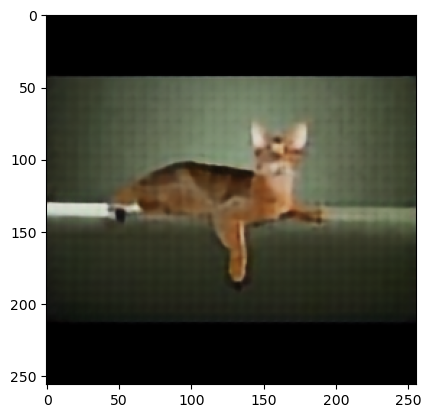

In [ ]:

from tqdm import tqdm
import torch
import os

batch_size = 4
target_batch_size = 64
accumulation_steps = target_batch_size // batch_size

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
    
model = ReconstructionAutoencoder(din=3, dout=3).to(device)
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


checkpoint = torch.load(f"results/checkpoint_256_no_aug.pytorch", map_location=device)

# Load model state
model.load_state_dict(checkpoint["model_state_dict"])
print(" -> Model state loaded.")

# Load optimizer state
try:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(" -> Optimizer state loaded.")
except Exception as e:
    print(f" -> Warning: Could not load optimizer state: {e}. Optimizer will start from scratch.")

# Load training metadata
best_epoch = checkpoint["epoch"] # Load last completed epoch, training continues from next one
best_val_loss = checkpoint.get("best_val_loss", np.inf)

print(f" -> Best validation loss from checkpoint: {best_val_loss:.6f}")

print(f" -> Resuming training from epoch {best_epoch}")
loaded_notes = checkpoint.get("notes", "N/A")
print(f" -> Notes from checkpoint: {loaded_notes}")

# Find correct debug val loss
val_loss, debug_val_loss = evalReconstruction(val_dataloader, model, loss_fn)
print(f"Debug Validation loss: {debug_val_loss:.6f}")
print(f"Validation loss: {val_loss:.6f}")


img, label = training_data[0]
img = img.to(device)
res = model(img.unsqueeze(0))
plt.imshow(res[0].permute(1,2,0).cpu().detach().numpy())
plt.savefig(f"results/256_no_aug.png", format="png")
plt.show()

In [103]:
print(len(val_dataloader))
print(target_batch_size)
print(len(val_dataloader) * target_batch_size)
print(len(val_dataloader) * 32)


185
64
11840
5920
